In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Any, Dict, Optional, List, Tuple
from mlagents.trainers.models import EncoderType
from mlagents.trainers.models import ModelUtils
from mlagents.tf_utils import tf
from mlagents import tf_utils

Instructions for updating:
non-resource variables are not supported in the long term


In [39]:
from mlagents.trainers.policy.transfer_policy import TransferPolicy, GaussianEncoderDistribution

In [2]:
from sklearn.manifold import TSNE

In [55]:
class Encoder:
    def __init__(self, path, h_size, feature_size, num_layers, input_size, act_size, action_layers,
                 action_features, forward_layers):
        
        self.act_size = act_size
        
        self.graph = tf.Graph()
        self.sess = tf.Session(config=tf_utils.generate_session_config(), graph=self.graph)
        
        with self.graph.as_default():
            self.vector_in = ModelUtils.create_vector_input(input_size)
            self.current_action = tf.placeholder(
                shape=[None, self.act_size],
                dtype=tf.float32,
                name="current_action",
            )
            self.encoder = self._create_encoder([], self.vector_in, h_size, feature_size, num_layers, "simple")
            self.action_encoder = self._create_action_encoder(self.current_action, h_size, action_features,
                                                              action_layers)
            self._create_forward_model(self.encoder, self.action_encoder, h_size, feature_size, forward_layers)
            for scope in ["encoding", "action_enc", "predict"]:
                self._load_scope(path, tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope), scope)
        
    def _create_encoder(
        self,
        visual_in: List[tf.Tensor],
        vector_in: tf.Tensor,
        h_size: int,
        feature_size: int,
        num_layers: int,
        vis_encode_type: EncoderType,
    ) -> tf.Tensor:
        with tf.variable_scope("encoding"):
            hidden_stream = ModelUtils.create_observation_streams(
                visual_in,
                vector_in,
                1,
                h_size,
                num_layers,
                vis_encode_type,
            )[0]

            latent = tf.layers.dense(
                    hidden_stream,
                    feature_size,
                    name="latent",
#                     activation=ModelUtils.swish,
                    kernel_initializer=tf.initializers.variance_scaling(1.0),
                )
        return latent
    
    def _create_action_encoder(
        self,
        action: tf.Tensor,
        h_size: int,
        action_feature_size: int,
        num_layers: int,
        reuse: bool=False
    ) -> tf.Tensor:
        
        hidden_stream = ModelUtils.create_vector_observation_encoder(
            action, 
            h_size, 
            ModelUtils.swish,
            num_layers, 
            scope="action_enc",
            reuse=reuse
        )

        with tf.variable_scope("action_enc"):
            latent = tf.layers.dense(
                hidden_stream,
                action_feature_size,
                name="latent",
                activation=tf.tanh,  
                kernel_initializer=tf.initializers.variance_scaling(1.0),
                reuse=reuse
            )
        return latent
    
    def _create_forward_model(
        self,
        encoded_state: tf.Tensor,
        encoded_action: tf.Tensor,
        h_size: int,
        feature_size: int,
        forward_layers: int,
        var_predict: bool = True,
    ) -> None:
        combined_input = tf.concat([encoded_state, encoded_action], axis=1)
        hidden = combined_input
        
        with tf.variable_scope("predict"):

            for i in range(forward_layers):
                hidden = tf.layers.dense(
                    hidden,
                    h_size,
                    name="hidden_{}".format(i),
                    activation=ModelUtils.swish,
                )

            if var_predict:
                self.predict_distribution = GaussianEncoderDistribution(
                    hidden, feature_size
                )
                self.predict = self.predict_distribution.sample()
            else:
                self.predict = tf.layers.dense(
                    hidden,
                    feature_size,
                    name="latent",
                )

    def _load_scope(self, path, variables, scope):
        saver = tf.train.Saver(variables)
        checkpoint = os.path.join(path, f"{scope}.ckpt")
        saver.restore(self.sess, checkpoint)
    
    def get_single_feature(self, obs):
        with self.graph.as_default():
            encoded = self.sess.run(self.encoder, feed_dict={self.vector_in: [obs]})
        return encoded[0]
    
    def get_single_predict(self, obs, action):
        with self.graph.as_default():
            predict = self.sess.run(self.predict, feed_dict={self.vector_in: [obs], self.current_action: [action]})
        return predict[0]

In [91]:
def my_color(i, j):
    i = (i+1)/2
    j = (j+1)/2
    return (i, j, max(0,1-i-j))

def build_obs(i, j, obs_type, extra_size=10):
    
    if obs_type == "normal":
        return i, j
    elif obs_type == "rich1":
        return i+j, i-j, i*j
    elif obs_type == "rich2":
        return i*j, 2*i+j, 2*j-j
    elif obs_type == "long":
        obs = []
        obs.append(i)
        obs.append(j)
        for _ in range(extra_size):
            obs.append(1.0)
        return obs
    elif obs_type == "longpre":
        obs = []
        for _ in range(extra_size):
            obs.append(1.0)
        obs.append(i)
        obs.append(j)
        return obs
    elif obs_type == "longn":
        obs = []
        for _ in range(extra_size):
            obs.append(np.random.randn())
        obs.append(i)
        obs.append(j)
        return obs
    elif obs_type == "longnpre":
        obs = []
        for _ in range(extra_size):
            obs.append(np.random.randn())
        obs.append(i)
        obs.append(j)
        return obs

def plot_features(encoder: Encoder, obs_type="normal"):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    plt.subplots_adjust(wspace=1)
    
    goals = [[1,1], [-1,-1], [0.1, 0.3]]
    for i in x:
        for j in y:
            axs[0, 0].scatter(i, j, color=my_color(i,j))
            
            f1, g1 = encoder.get_single_feature(list(goals[0]) + list(build_obs(i,j,obs_type)))
            axs[0, 1].scatter(f1, g1, color=my_color(i,j))
            
            f2, g2 = encoder.get_single_feature(list(goals[1]) + list(build_obs(i,j,obs_type)))
            axs[1, 0].scatter(f2, g2, color=my_color(i,j))
            
            f3, g3 = encoder.get_single_feature(list(goals[2]) + list(build_obs(i,j,obs_type)))
            axs[1, 1].scatter(f3, g3, color=my_color(i,j))
            
    axs[0, 0].set_title('Obs Space')
    axs[0, 1].set_title('Goal ' + str(goals[0]))
    axs[1, 0].set_title('Goal ' + str(goals[1]))
    axs[1, 1].set_title('Goal ' + str(goals[2]))

def compare_plots(encoders: List[Encoder], types: List[str], goal: list):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    n = len(types)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    x_min = 10000
    x_max = -10000
    y_min = 10000
    y_max = -10000
#     plt.subplots_adjust(wspace=1)
    
    for k in range(n):
        enc = encoders[k]
        t = types[k]
        for i in x:
            for j in y:
                f, g = enc.get_single_feature(goal + list(build_obs(i,j,t)))
                if f > x_max:
                    x_max = f
                if f < x_min:
                    x_min = f
                if g > y_max:
                    y_max = g
                if g < y_min:
                    y_min = g
                axs[k].scatter(f, g, color=my_color(i,j))
                axs[k].set_title(t)
    
    plt.setp(axs, xlim=(x_min,x_max), ylim=(y_min,y_max))

In [15]:
def tsne_plot(encoder, obs_type, goal, axs):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    feature_list = []
    color_list = []
    for i in x:
        for j in y:
            feature = encoder.get_single_feature(goal + list(build_obs(i,j,obs_type)))
            feature_list.append(feature)
            color_list.append(my_color(i,j))
    feature_list = np.array(feature_list)
    tsne = TSNE()
    embedded = tsne.fit_transform(feature_list)
    for n in range(len(embedded)):
        axs.scatter(embedded[n][0], embedded[n][1], color=color_list[n])

In [60]:
def tsne_plot_predict(encoder, obs_type, goal, action, axs):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    feature_list = []
    color_list = []
    for i in x:
        for j in y:
            feature = encoder.get_single_predict(goal + list(build_obs(i,j,obs_type)), action)
            feature_list.append(feature)
            color_list.append(my_color(i,j))
    feature_list = np.array(feature_list)
    tsne = TSNE()
    embedded = tsne.fit_transform(feature_list)
    for n in range(len(embedded)):
        axs.scatter(embedded[n][0], embedded[n][1], color=color_list[n])

In [72]:
def tsne_plot_next(encoder, obs_type, goal, action, axs):
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    for a in range(len(action)):
        if action[a] > 0.1:
            action[a] = 0.1
    print("action:", action)
    feature_list = []
    color_list = []
    for i in x:
        for j in y:
            feature = encoder.get_single_feature(goal + list(build_obs(i+action[0],j+action[1],obs_type)))
            feature_list.append(feature)
            color_list.append(my_color(i,j))
    feature_list = np.array(feature_list)
    tsne = TSNE()
    embedded = tsne.fit_transform(feature_list)
    for n in range(len(embedded)):
        axs.scatter(embedded[n][0], embedded[n][1], color=color_list[n])

In [113]:
def tsne_plot_compare(encoder, obs_type, goal, action):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    x = np.arange(-1,1,0.1)
    y = np.arange(-1,1,0.1)
    feature_list = []
    color_list = []
    real_action = []
    for a in range(len(action)):
        if action[a] > 0.1:
            real_action.append(0.1)
        else:
            real_action.append(action[a])
            
    for i in x:
        for j in y:
            feature = encoder.get_single_feature(goal + list(build_obs(i,j,obs_type)))
            feature_list.append(feature)
            color_list.append(my_color(i,j))
    for i in x:
        for j in y:     
            feature_pred = encoder.get_single_predict(goal + list(build_obs(i,j,obs_type)), action)
            feature_list.append(feature)
    
    for i in x:
        for j in y:  
            feature_next = encoder.get_single_feature(goal + list(build_obs(i+real_action[0],j+real_action[1],obs_type)))
            feature_list.append(feature)
            
    num = len(color_list)
    feature_list = np.array(feature_list)
    tsne = TSNE()
    embedded = tsne.fit_transform(feature_list)
    print(num, len(embedded))
    for i in range(3):
        for n in range(i*num, (i+1)*num):
            axs[i].scatter(embedded[n][0], embedded[n][1], color=color_list[n%num])

In [33]:
normal_encoder = Encoder("./transfer_results/model_normal_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 4)
long_encoder = Encoder("./transfer_results/model_long_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14)
longpre_encoder = Encoder("./transfer_results/model_longpre_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14)
long_transfer_encoder = Encoder("./transfer_results/normal_transfer_to_long_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)
longpre_transfer_encoder = Encoder("./transfer_results/normal_transfer_to_longpre_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)
long_transfer_linear_encoder = Encoder("./transfer_results/normal_transfer_linear_to_long_s0/Simple", h_size = 32, 
                         feature_size = 16, num_layers = 2, input_size = 14)

INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_longpre_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_longpre_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_linear_to_long_s0/Simple/encoding.ckpt


Text(0.5, 1.0, 'normal transfer to longpre')

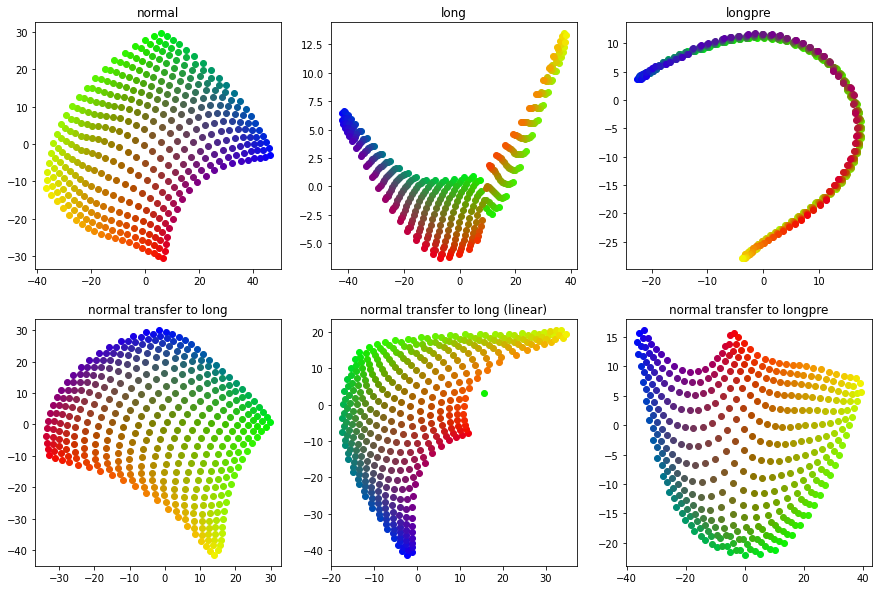

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
goal = [0.5, -0.5]
tsne_plot(normal_encoder, "normal", goal, axs[0][0])
tsne_plot(long_encoder, "long",goal, axs[0][1])
tsne_plot(longpre_encoder, "long", goal, axs[0][2])
tsne_plot(long_transfer_encoder, "long", goal, axs[1][0])
tsne_plot(long_transfer_linear_encoder, "long", goal, axs[1][1])
tsne_plot(longpre_transfer_encoder, "longpre", goal, axs[1][2])
axs[0][0].set_title("normal")
axs[0][1].set_title("long")
axs[0][2].set_title("longpre")
axs[1][0].set_title("normal transfer to long")
axs[1][1].set_title("normal transfer to long (linear)")
axs[1][2].set_title("normal transfer to longpre")

INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s3/Simple/encoding.ckpt


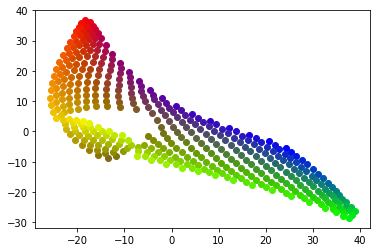

In [29]:
long_encoder = Encoder("./transfer_results/model_long_s3/Simple", h_size = 64, feature_size = 32,
                    num_layers = 2, input_size = 14)
tsne_plot(long_encoder, "long", [1,1], plt)

In [121]:
normal_encoder = Encoder("./transfer_results/model_normal_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 4, act_size=2, action_layers=1, action_features=4, forward_layers=0)
long_encoder = Encoder("./transfer_results/model_long_s2/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14, act_size=2, action_layers=1, action_features=4, forward_layers=0)
transfer_encoder = Encoder("./transfer_results/normal_transfer_to_long_s0/Simple", h_size = 32, feature_size = 16,
                    num_layers = 2, input_size = 14, act_size=2, action_layers=1, action_features=4, forward_layers=0)

INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/action_enc.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/predict.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s2/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s2/Simple/action_enc.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/model_long_s2/Simple/predict.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s0/Simple/encoding.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s0/Simple/action_enc.ckpt
INFO:tensorflow:Restoring parameters from ./transfer_results/normal_transfer_to_long_s0/Simple/predict.ckpt


Text(0.5, 1.0, 'long-n')

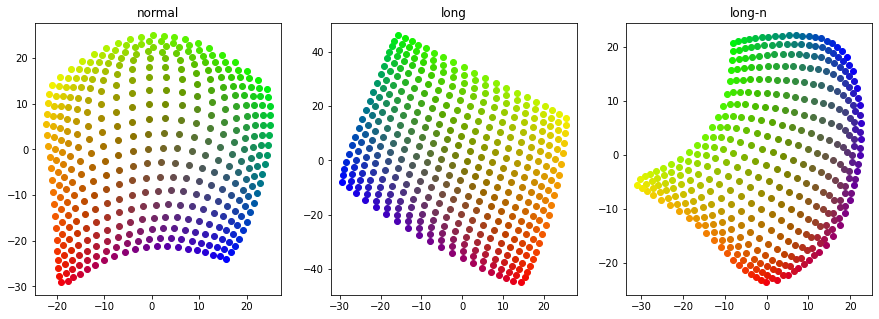

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
goal = [0,0]
tsne_plot(normal_encoder, "normal", goal, axs[0])
tsne_plot(long_encoder, "long",goal, axs[1])
tsne_plot(transfer_encoder, "long", goal, axs[2])
axs[0].set_title("normal")
axs[1].set_title("long")
axs[2].set_title("long-trasnfer")

Text(0.5, 1.0, 'long-n')

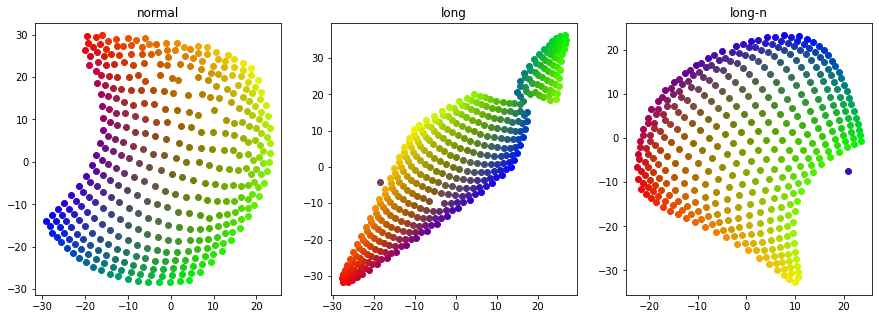

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
goal = [0,0]
action = [0.1, 0.1]
tsne_plot_predict(normal_encoder, "normal", goal, action, axs[0])
tsne_plot_predict(long_encoder, "long", goal, action, axs[1])
tsne_plot_predict(transfer_encoder, "long", goal, action, axs[2])
axs[0].set_title("normal")
axs[1].set_title("long")
axs[2].set_title("long-n")

action: [0.1, 0.1]
action: [0.1, 0.1]
action: [0.1, 0.1]


Text(0.5, 1.0, 'long-n')

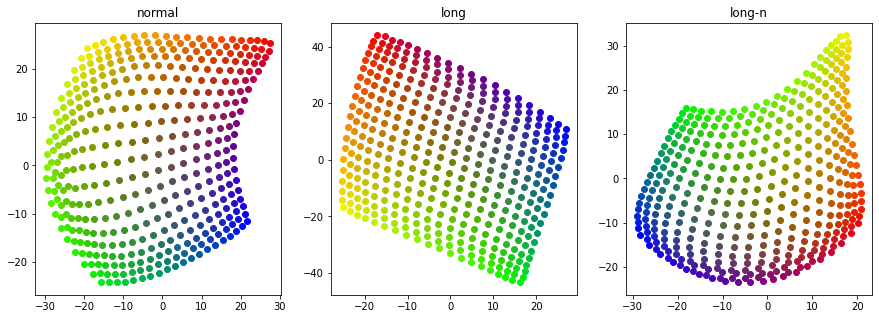

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
goal = [0,0]
action = [0.1, 0.1]
tsne_plot_next(normal_encoder, "normal", goal, action, axs[0])
tsne_plot_next(long_encoder, "long", goal, action, axs[1])
tsne_plot_next(transfer_encoder, "long", goal, action, axs[2])
axs[0].set_title("normal")
axs[1].set_title("long")
axs[2].set_title("long-n")

In [120]:
for encoder, obs in zip([normal_encoder, long_encoder, longn_encoder], ["normal", "long", "long"]):
    pred = encoder.get_single_predict([0,0] + list(build_obs(0, 0, obs)), [0.5, 0.5])
    next_obs = encoder.get_single_feature([0,0] + list(build_obs(0.1, 0.1, obs)))
    print(np.linalg.norm(pred-next_obs))

0.6450534
37.881687
2.6910596


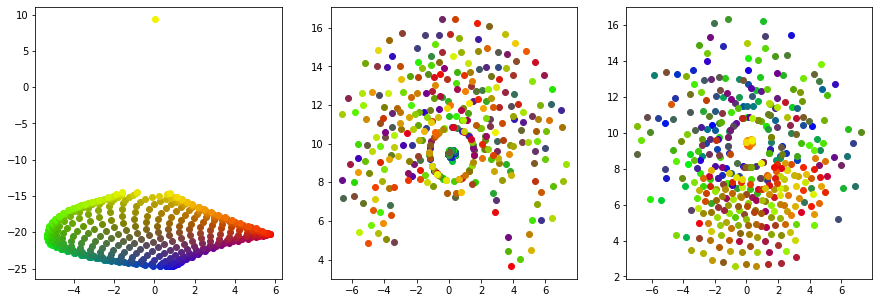

In [112]:
goal = [0,0]
action = [0.1, 0.1]
tsne_plot_compare(normal_encoder, "normal", goal, action)